<a href="https://colab.research.google.com/github/lucaskrlima/bootcamp-machine-learning-atlantico/blob/main/%5BAvanti_Bootcamp_ML_Etapa_1%5D_X_Ray_Baggage_Scanner_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto de Detecção de ameaças e anomalias baseada em aprendizado profundo em varreduras de bagagem de segurança - Etapa 1**

## Detecção de anomalias em varreduras de bagagem por raio-X usando aprendizado profundo. O modelo identifica 5 itens potencialmente perigosos: arma de fogo, faca, alicate, tesoura e chave inglesa, apoiando a vigilância inteligente em sistemas de segurança aeroportuária.

## **1. Baixar o Dataset do Kaggle**

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install imagehash
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/orvile/x-ray-baggage-anomaly-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: eduardanogueira88
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/orvile/x-ray-baggage-anomaly-detection


100%|██████████| 133M/133M [00:00<00:00, 1.09GB/s]

In [ ]:
!ls x-ray-baggage-anomaly-detection

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


## **2. Criar um Dataframe com os metadados das imagens**

### *Parte 1 - Importar bibliotecas*

In [ ]:
import os
import cv2
import pandas as pd
import imagehash
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt


### *Parte 2 - Definiir o caminho e preparar estruturas*

In [ ]:
root_dir = 'x-ray-baggage-anomaly-detection'

# Mapeamento fixo dos IDs para nomes
class_map = {
    '0': 'gun',
    '1': 'knife',
    '2': 'pliers',
    '3': 'scissors',
    '4': 'wrench'
}

dataframe_list = []     # Lista para armazenar os dados das imagens
count_corrupted = 0     # Contador de imagens corrompidas
corrupted = []          # Lista com os caminhos das imagens corrompidas


### *Parte 3 - Percorrer cada pasta*

In [ ]:
def get_image_classes(label_path):
    if not os.path.exists(label_path):
        return []
    with open(label_path, 'r') as f:
        lines = f.readlines()
    classes = set()
    for line in lines:
        # Pega o ID da classe e traduz para o nome com o class_map
        class_id = line.strip().split()[0]
        class_name = class_map.get(class_id, f"unknown_{class_id}")
        classes.add(class_name)
    return list(classes)

for split in ['train', 'valid', 'test']:
    image_folder = os.path.join(root_dir, split, 'images')
    label_folder = os.path.join(root_dir, split, 'labels')

    for image_name in os.listdir(image_folder):
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        image_path = os.path.join(image_folder, image_name)
        label_path = os.path.join(label_folder, os.path.splitext(image_name)[0] + '.txt')

        # Extrai as classes presentes na imagem
        image_classes = get_image_classes(label_path)
        image_class_str = ','.join(image_classes) if image_classes else 'none'

        # Tenta ler a imagem para pegar informações e gerar hash
        img = cv2.imread(image_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)
            img_hash = str(imagehash.phash(img_pil))
            height, width, channels = img.shape
            img_format = image_name.split('.')[-1].lower()
            img_corrupted = False
            file_size = os.path.getsize(image_path)
        else:
            # Caso a imagem esteja corrompida ou inválida
            img_corrupted = True
            img_hash = None
            img_format = None
            width = height = channels = None
            file_size = os.path.getsize(image_path)
            count_corrupted += 1
            corrupted.append(image_path)

        # Adiciona os dados coletados na lista para criar o DataFrame depois
        dataframe_list.append([
            image_path, image_class_str, img_corrupted, img_hash, img_format,
            width, height, channels, file_size, split
        ])


### *Parte 4 - Criar o DataFrame*

In [ ]:
# Criar DataFrame
df = pd.DataFrame(dataframe_list, columns=[
    'image_path', 'class', 'corrupted', 'image_hash', 'image_format',
    'width', 'height', 'channels', 'file_size_bytes', 'split'
])

# Resultados
print(f"Total de imagens corrompidas: {count_corrupted}")
print("Exemplo de imagens corrompidas:", corrupted[:5])

# Visualizar as primeiras linhas
df.head()

Total de imagens corrompidas: 0
Exemplo de imagens corrompidas: []


,image_path,class,corrupted,image_hash,image_format,width,height,channels,file_size_bytes,split
0,x-ray-baggage-anomaly-detection/train/images/0...,knife,False,e4659b92646d6764,jpg,416,416,3,13756,train
1,x-ray-baggage-anomaly-detection/train/images/0...,knife,False,e19a9e6561db3384,jpg,416,416,3,12569,train
2,x-ray-baggage-anomaly-detection/train/images/0...,wrench,False,b4cbc33438709acf,jpg,416,416,3,21650,train
3,x-ray-baggage-anomaly-detection/train/images/0...,knife,False,ba38c5c76b303c6c,jpg,416,416,3,22630,train
4,x-ray-baggage-anomaly-detection/train/images/0...,knife,False,8de5f21a0db452e9,jpg,416,416,3,26869,train


In [ ]:
df['split'].value_counts()


,count
split,
train,6181
valid,1766
test,883


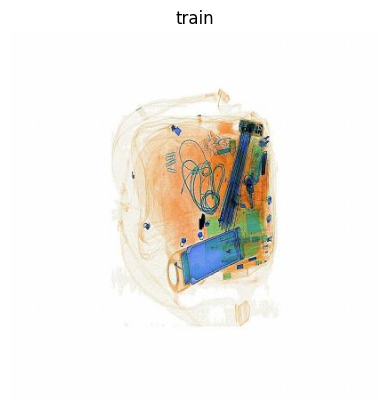

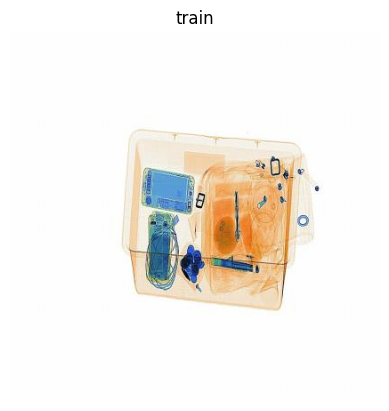

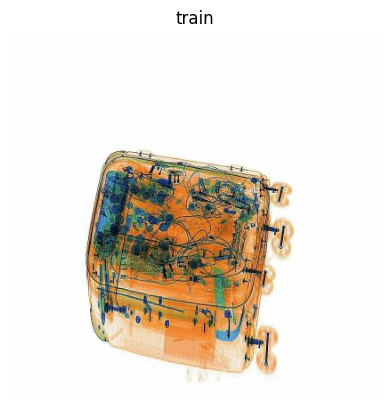

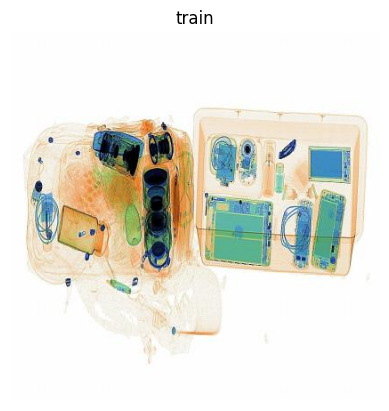

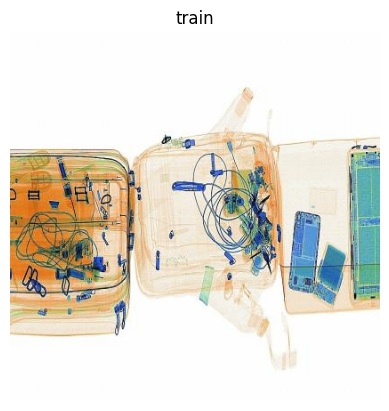

In [ ]:
import matplotlib.pyplot as plt

# Exibir as 5 primeiras imagens do DataFrame
for i in range(5):
    img = cv2.imread(df.iloc[i]['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(df.iloc[i]['split'])
    plt.axis('off')
    plt.show()


### *Parte 5 -  Salvar DataFrame em CSV*

In [ ]:
df.to_csv('metadados_imagens.csv', index=False)

## **3. Verificar a Integridade dos Arquivos**

Primeiro, vamos verificar se existe arquivo corrompido ```df[corrupted] == True```.

In [ ]:
df['corrupted'].sum()

np.int64(0)

Não há arquivo corrompido.

In [ ]:
df.describe().loc[['mean', 'std', 'min', 'max']]

,width,height,channels,file_size_bytes
mean,416.0,416.0,3.0,16855.056512
std,0.0,0.0,0.0,5165.782355
min,416.0,416.0,3.0,5429.000000
max,416.0,416.0,3.0,39670.000000


Pode-se perceber que todas as imagens possuem o mesmo tamanho, variando apenas o tamanho dos arquivos.

In [ ]:
df[['split','image_format']].value_counts()

,,count
split,image_format,
train,jpg,6181
valid,jpg,1766
test,jpg,883


Todas as imagens estão no formato ```.jpg```

## **4. Verificar a Consistência dos Metadados**

In [ ]:
import os
from PIL import Image, UnidentifiedImageError

dataset_path = "./x-ray-baggage-anomaly-detection"

target_folder = os.path.join(dataset_path, "train")  ## aqui nos mudamos para o de val e de test,

def is_corrupted(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        with Image.open(filepath) as img:
            img.load()
        return False
    except (UnidentifiedImageError, IOError, SyntaxError):
        return True

def is_zero_byte(filepath):
    return os.path.getsize(filepath) == 0

def is_one_by_one(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size == (1, 1)
    except:
        return False

def check_images(folder_path):
    corrupted_files = []
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff")):
                filepath = os.path.join(root, filename)

                if is_zero_byte(filepath):
                    print(f"Zero byte: {filepath}")
                    corrupted_files.append(filepath)
                elif is_corrupted(filepath):
                    print(f"Corrompida (não abre): {filepath}")
                    corrupted_files.append(filepath)
                elif is_one_by_one(filepath):
                    print(f"Imagem 1x1 pixel: {filepath}")
                    corrupted_files.append(filepath)

    return corrupted_files

if __name__ == "__main__":
    print(f"Verificando imagens na pasta: {target_folder}")
    corrompidas = check_images(target_folder)

    print(f"\nTotal de imagens problemáticas encontradas: {len(corrompidas)}")

    for img_path in corrompidas:
        try:
            os.remove(img_path)
            print(f"Imagem removida: {img_path}")
        except Exception as e:
            print(f"Erro ao tentar remover {img_path}: {e}")



Verificando imagens na pasta: ./x-ray-baggage-anomaly-detection/train

Total de imagens problemáticas encontradas: 0


## **5. Analisar a Qualidade das Imagens**

Downloading: "https://github.com/photosynthesis-team/piq/releases/download/v0.4.0/brisque_svm_weights.pt" to /root/.cache/torch/hub/checkpoints/brisque_svm_weights.pt
100%|██████████| 112k/112k [00:00<00:00, 5.08MB/s]



Resumo Estatístico:
       altura  largura     desfoque      brilho     brisque
count   883.0    883.0   883.000000  883.000000  883.000000
mean    416.0    416.0  1294.307169  233.412997   70.250530
std       0.0      0.0   644.037606    8.641869   12.741498
min     416.0    416.0    66.495551  199.484150   31.382996
25%     416.0    416.0   809.224800  227.895048   60.893738
50%     416.0    416.0  1204.924441  233.882050   71.574402
75%     416.0    416.0  1708.107809  240.729085   79.925476
max     416.0    416.0  3563.671167  249.652147  115.232605


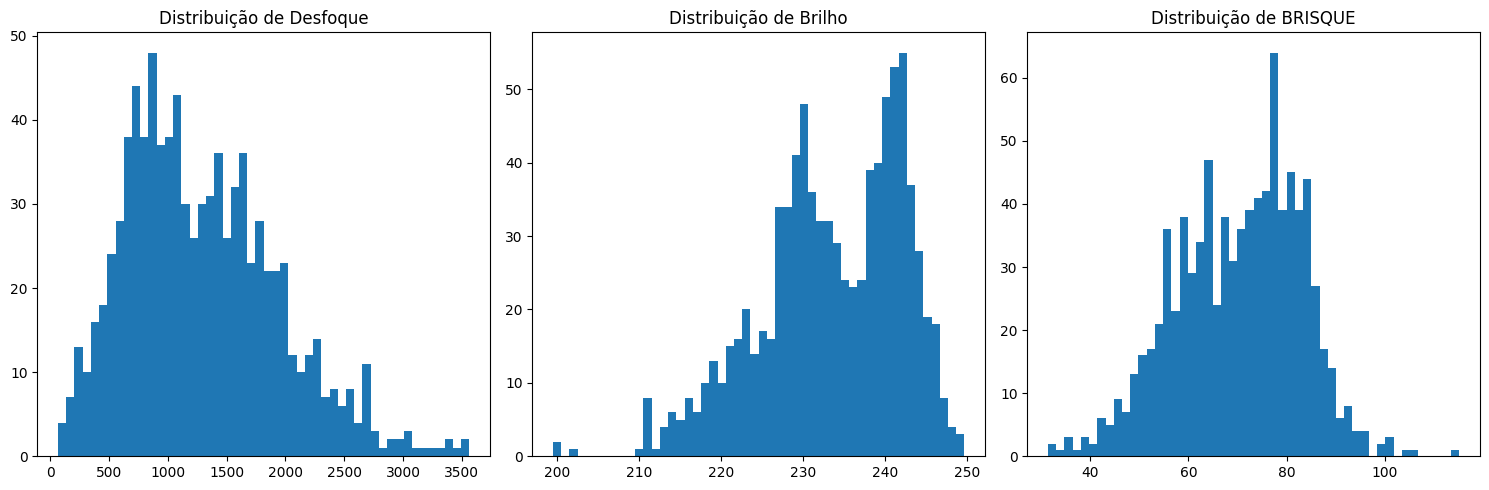

In [ ]:
'''
Quando analisamos dados relacionados a detecção de anomalias por raio-x, o que
que aspecto das qualidade das imagens podemos investigar?
'''
#importando bibliotecas padrão
import numpy as np
import matplotlib.pyplot as plt
import torch
import piq

# Caminho do dataset
DATASET_PATH = "/content/x-ray-baggage-anomaly-detection/test/images"

# Lista de imagens
imagens = [p for p in os.listdir(DATASET_PATH) if p.endswith(('.jpg', '.png', '.jpeg'))]

# Inicializar lista de métricas
metricas = []

def qualy_image(file_path):
    try:
        img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img_color = cv2.imread(file_path)

        # Tamanho
        a, l = img_gray.shape

        # Desfoque
        desfoque = cv2.Laplacian(img_gray, cv2.CV_64F).var()

        # Brilho
        brilho = np.mean(img_gray)

        # Hash
        hash_val = str(imagehash.phash(Image.open(file_path)))

        # BRISQUE
        img_tensor = torch.from_numpy(img_color / 255.).permute(2, 0, 1).unsqueeze(0).float()
        brisque_score = piq.brisque(img_tensor, data_range=1.0).item()

        return a, l, desfoque, brilho, brisque_score, hash_val

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None

# Processamento das imagens
for pasta in imagens:
    full_path = os.path.join(DATASET_PATH, pasta)
    result = qualy_image(full_path)
    if result:
        a, l, desfoque, brilho, brisque, hash_val = result
        metricas.append([pasta, a, l, desfoque, brilho, brisque, hash_val])

# Criar DataFrame
columns = ["filename", "altura", "largura", "desfoque", "brilho", "brisque", "hash"]
df = pd.DataFrame(metricas, columns=columns)

# Detectar duplicatas
duplicates = df[df.duplicated('hash', keep=False)]

# Exibir estatísticas
print("\nResumo Estatístico:")
print(df.describe())

# Plotar gráficos
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(df['desfoque'], bins=50)
plt.title("Distribuição de Desfoque")

plt.subplot(1, 3, 2)
plt.hist(df['brilho'], bins=50)
plt.title("Distribuição de Brilho")

plt.subplot(1, 3, 3)
plt.hist(df['brisque'], bins=50)
plt.title("Distribuição de BRISQUE")

plt.tight_layout()
plt.show()


Interpretação:

* Altura e largura com a maioria com tamanho de 416x416 pixels para todas as imagens. O que indica um dataset padronizado.

* O Desfoque é uma métrica que quanto maior melhor. Imagens com desfoque > 1000 são geralmente mais nítidas, neste caso temos como média ~1294. Como ponto de atenção 25% das imagens estão abaixo de 809.

* Brilho possui média ~233 e desvio padrão ~8.6, essa dispersão baixa indica imagens com brilho consistente.

* Brisque (Indíce de qualidade de imagem sem referência)
A escala que mede Brisque vai de 0 a 100 sendo que quanto menor a medida melhor a qualidade visual. Temos uma média ~70, variando entre 60 e 80, indicando uma qualidade moderada.

## **6. Verificar a Distribuição das Classes**

### *Estruturar pastas com suas labels*

In [ ]:
root_dir = 'x-ray-baggage-anomaly-detection'
pastas = [os.path.join(root_dir, 'train', 'labels'),
          os.path.join(root_dir, 'valid', 'labels'),
          os.path.join(root_dir, 'test', 'labels')]


contagem_total = Counter()
for pasta in pastas:
    for arquivo in os.listdir(pasta):
        if arquivo.endswith('.txt'):
            with open(os.path.join(pasta, arquivo), 'r') as f:
                for linha in f:
                    classe_id = linha.strip().split()[0]
                    contagem_total[classe_id] += 1

### *Criando Dataframe e Mapeando o nome das minhas classes*


In [ ]:
df = pd.DataFrame(contagem_total.items(), columns=['label_id', 'count'])
df['label'] = df['label_id'].map(class_map)


###*Plotando meu Gráfico*

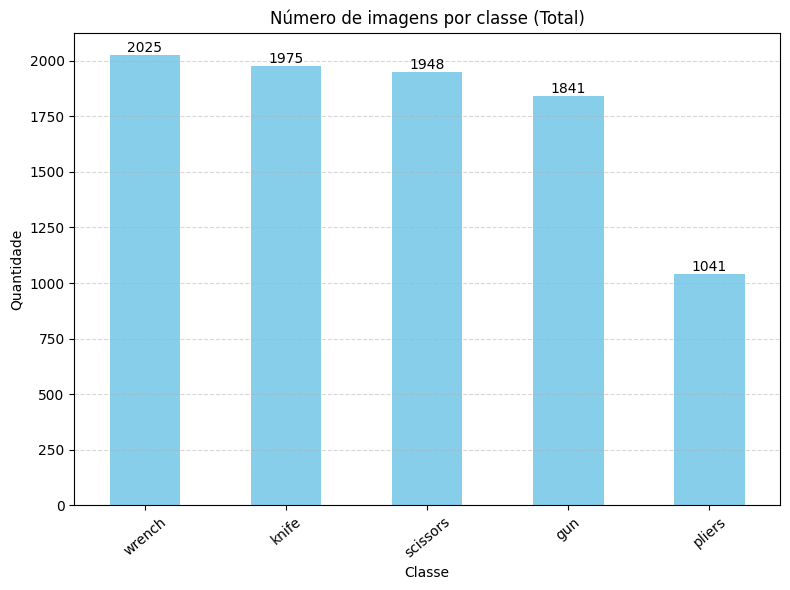

In [ ]:
ax = df.set_index('label')['count'].sort_values(ascending=False).plot(
    kind='bar', title='Número de imagens por classe (Total)', figsize=(8, 6), color='skyblue'
)

plt.xticks(rotation=40)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## **7. Verificar a Presença de Duplicatas**

In [ ]:
import os
import cv2
import hashlib

imagens = "/content/x-ray-baggage-anomaly-detection/test/images"

hashes = {}
duplicadas = []

for arquivo in os.listdir(imagens):
    if not arquivo.lower().endswith(('.jpg')):
        continue
    caminho = os.path.join(imagens, arquivo)
    img = cv2.imread(caminho)

    if img is None:
        continue

    img_bytes = img.tobytes()
    hash_img = hashlib.md5(img_bytes).hexdigest()

    if hash_img in hashes:
        duplicadas.append((arquivo, hashes[hash_img]))
    else:
        hashes[hash_img] = arquivo

if duplicadas:
    print("Duplicadas encontradas: \n")
    for dup in duplicadas:
        print(f"{dup[0]} ↔ {dup[1]}")
else:
    print("Nenhuma imagem duplicada foi encontrada.")

Nenhuma imagem duplicada foi encontrada.
